<a href="https://colab.research.google.com/github/sajjad5221/book-recommendation/blob/main/book_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The basic idea behind analysing the Goodreads dataset is to get a fair idea about the relationships between the multiple attributes a book might have, such as:the aggregrate rating of each book, the trend of the authors over the years and books with numerous languages. With over a hundred thousand ratings, there are books which just tend to become popular as each day seems to pass.

We've always conisdered the magical persona books seem to hold, and with this notebook, we step out on a journey to see what kind of books really drives people to read in this era of modern smart devices.

With such a vast, overwhelming number of factors, we'll go over such demographics:

* Does any relationship lie between ratings and the total ratings given?
*   Where do majority of the books lie, in terms of ratings - Does reading a book really bring forth bias for the ratings?

*   Do authors tend to perform same over time, with all their newer books? Or do they just fizzle out.
* Do number of pages make an impact on reading styles, ratings and popularity?
* Can books be recommended based on ratings? Is that a factor which can work?

Dataset description:

bookID Contains the unique ID for each book/series
title contains the titles of the books
authors contains the author of the particular book
average_rating the average rating of the books, as decided by the users
ISBN ISBN(10) number, tells the information about a book - such as edition and publisher
ISBN 13 The new format for ISBN, implemented in 2007. 13 digits
language_code Tells the language for the books
Num_pages Contains the number of pages for the book
Ratings_count Contains the number of ratings given for the book
text_reviews_count Has the count of reviews left by users

In [43]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
# import isbnlib
# from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
df = pd.read_csv('/content/drive/My Drive/master-university/data-mining/project/books.csv', error_bad_lines=False)

b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


In [47]:
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))

Dataset contains 13714 rows and 10 columns


In [48]:
df.head() 

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390
3,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964


In [49]:
df.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
# num_pages           0
ratings_count         0
text_reviews_count    0
dtype: int64

In [50]:
df.index = df['bookID']


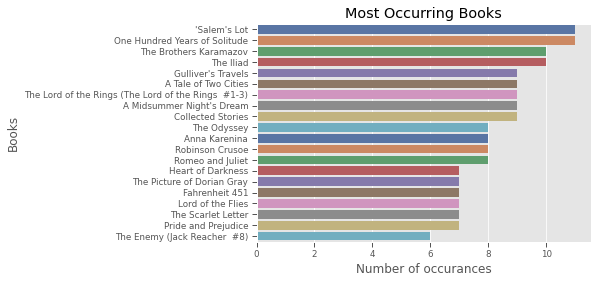

In [51]:
books = df['title'].value_counts()[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

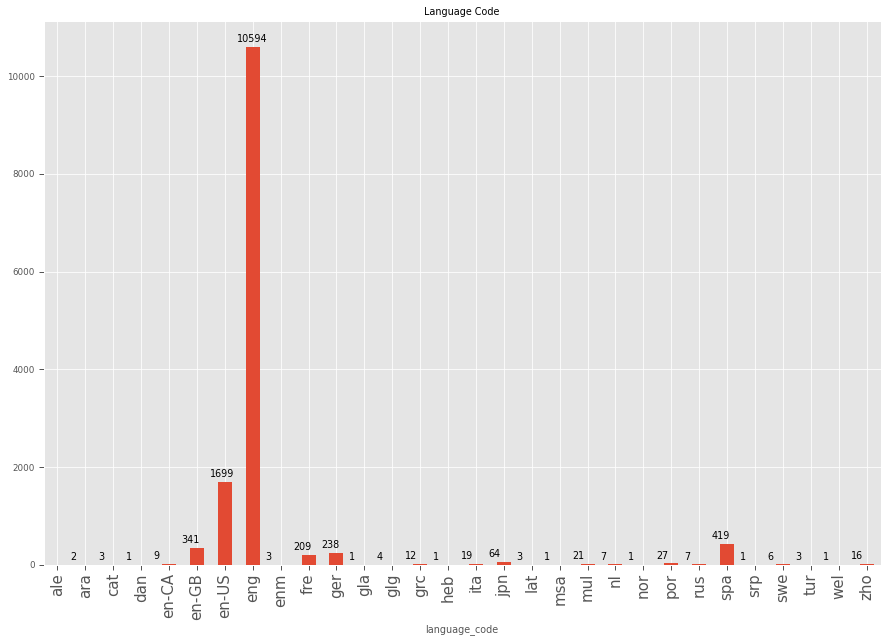

In [52]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

In [53]:
top_books = df[df['ratings_count'] > 1000000]

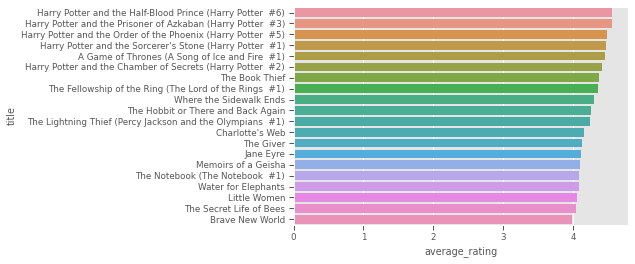

In [54]:
most_rated = top_books.sort_values(by='average_rating', ascending=False).head(20)
sns.barplot(most_rated.average_rating, most_rated.title)

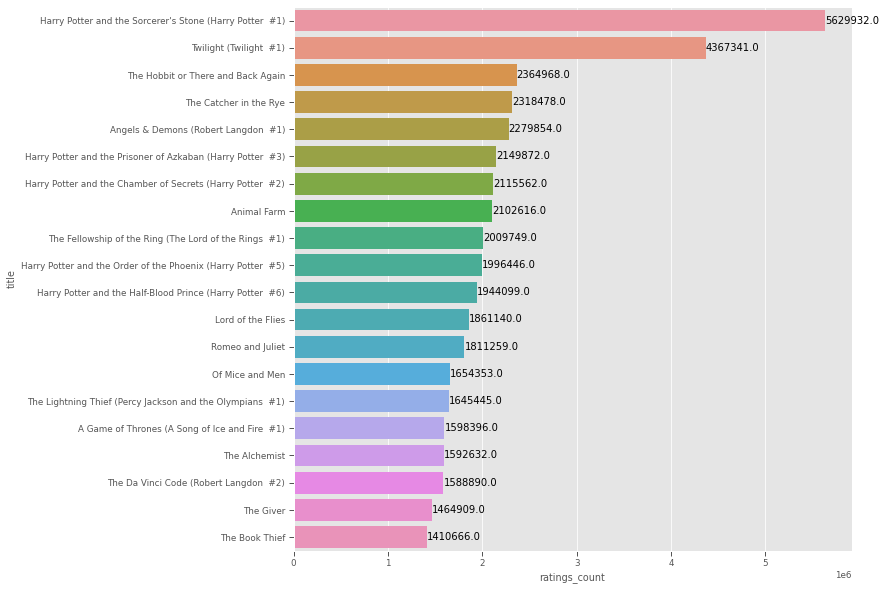

In [55]:
top_vote = df.sort_values(by='ratings_count', ascending=False).head(20)
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="ratings_count", y="title", data=top_vote)

for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()), fontsize = 10, color = 'k')
plt.show()

Top rated but not in top voted

In [56]:
list(set(top_books['title'].values) - set(top_vote['title'].values))

['Wuthering Heights',
 'Jane Eyre',
 'The Notebook (The Notebook  #1)',
 'Little Women',
 'Eat  Pray  Love',
 'Memoirs of a Geisha',
 'Brave New World',
 'The Secret Life of Bees',
 'Water for Elephants',
 "Charlotte's Web",
 'Where the Sidewalk Ends',
 'The Adventures of Huckleberry Finn']

Top voted but not in top rated

In [57]:
list(set(top_vote['title'].values) - set(top_books['title'].values))


[]

In [58]:
most_voted = df.sort_values(by = 'ratings_count',ascending= False).head(10)

Relationship between rating and vote


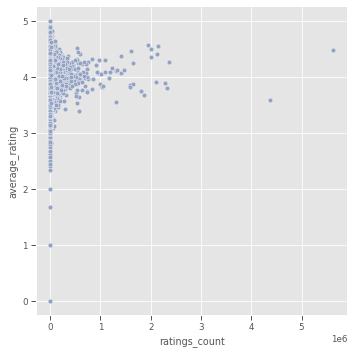

In [59]:
sns.relplot(x = "ratings_count", y = "average_rating",color = '#95a3c3', data = df)

We have some outlier data in ratings_count. It's better to handle them. 
First see them in box plot:

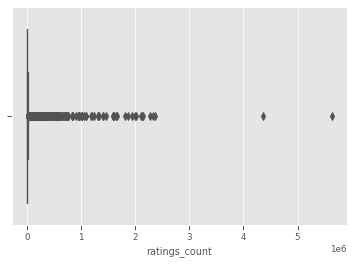

In [77]:
sns.boxplot(df.ratings_count)

Now we can handle them with quartile.

In [80]:
q3, q1 = np.percentile(df.ratings_count, [75 ,25])
iqr = q3 - q1
df.ratings_count[df.ratings_count < q1 - 1.5 * iqr] = q1 - 1.5 * iqr
df.ratings_count[df.ratings_count > q3 + 1.5 * iqr] = q3 + 1.5 * iqr

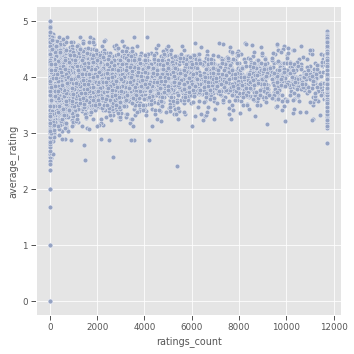

In [81]:
sns.relplot(x = "ratings_count", y = "average_rating",color = '#95a3c3', data = df)

In [60]:
new_data = df.copy()
def fun_only_author(text):
    arlen = text.split('-')
    return arlen[0]

new_data['only_author'] = new_data['authors'].apply(lambda x : fun_only_author(x))
total_rating = new_data.drop_duplicates(subset=['only_author', 'title'], keep='first')
total_rating = total_rating.groupby(by=['only_author']).agg({'average_rating': ['sum']})
total_rating.columns = ['total_rating']
total_rating.reset_index(inplace=True)
total_rating = total_rating.sort_values(by=['total_rating'], ascending=False)
total_rating

,only_author,total_rating
4126,Stephen King,360.18
32,Agatha Christie,308.57
4562,William Shakespeare,222.87
1775,J.R.R. Tolkien,213.68
3315,P.G. Wodehouse,204.84
...,...,...
3301,Open City Magazine,0.00
416,Better Homes and Gardens,0.00
3334,Paolo Mazzarello,0.00
4184,Stuart Mitchner,0.00


In [61]:
total_book = new_data.groupby(by=['only_author']).agg({'title' : ['nunique']})
total_book.columns = ['total_book']
total_book.reset_index(inplace=True)
total_book = total_book.sort_values(by = ['total_book'], ascending = False)
total_book

,only_author,total_book
4126,Stephen King,90
32,Agatha Christie,79
4562,William Shakespeare,56
1775,J.R.R. Tolkien,51
3315,P.G. Wodehouse,49
...,...,...
2512,L. John Mason,1
2513,L. Sprague de Camp,1
901,David Day,1
2515,L.A. Graf,1


Average rate for authors

In [72]:
avg_author = pd.merge(total_book,total_rating, how = 'inner', on = 'only_author')
avg_author['avg_rating'] = round(avg_author['total_rating']/avg_author['total_book'], 2)
avg_author

,only_author,total_book,total_rating,avg_rating
0,Stephen King,90,360.18,4.00
1,Agatha Christie,79,308.57,3.91
2,William Shakespeare,56,222.87,3.98
3,J.R.R. Tolkien,51,213.68,4.19
4,P.G. Wodehouse,49,204.84,4.18
...,...,...,...,...
4614,L. John Mason,1,4.22,4.22
4615,L. Sprague de Camp,1,3.64,3.64
4616,David Day,1,4.13,4.13
4617,L.A. Graf,1,3.65,3.65


Draw rating chart

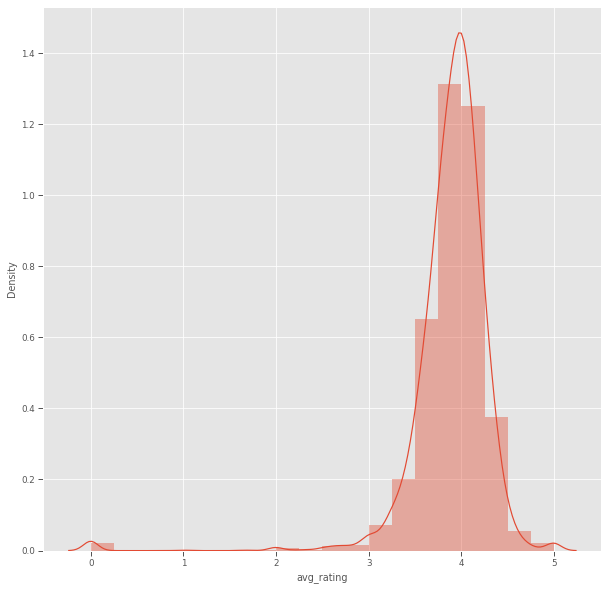

In [73]:
plt.figure(figsize=(10,10))
rating= avg_author.avg_rating.astype(float)
sns.distplot(rating, bins=20)

From the given plot, we can infer that:
*   Majority of the ratings lie near 3.7-4.3, approximately.
*   Books having scores near 5 are extremely rare

